# University of Niagara Falls Canada
## Master of Data Analytics
### DAMO630 – Advanced Data Analytics
# Assignment 2
## Group 4
- Kojo Foli
- Mario Zamudio
- Teddy Baeny
- Carlos Borda

### November, 2025

# Business Challenge 2: Books Recommendation System Development

## Business Context

Digital book platforms (similar to Goodreads or Amazon Kindle) face the challenge of:
- Identifying similar books to enhance discovery
- Recommending books to readers that they are most likely to enjoy
- Leveraging past ratings and collective user behavior patterns

This notebook implements a collaborative filtering recommendation system using the **Alternating Least Squares (ALS)** algorithm on the Goodbooks-10k dataset.

---

## Dataset Overview

**Goodbooks-10k Dataset:**
- Contains over 6 million ratings from 50,000+ users
- Covers 10,000 unique books
- Ratings range from 1 (lowest) to 5 (highest)
- Typical sparse dataset where most users rate only a handful of books

**File Structure:**
- `user_id`: Anonymized user identifier
- `book_id`: Book identifier
- `rating`: User rating (1-5 scale)

## 1. Import Required Libraries

In [1]:
# # Install required libraries
# !pip install implicit
# !pip install wordcloud

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Sparse matrix operations
from scipy.sparse import csr_matrix

# ALS model from implicit library
from implicit.als import AlternatingLeastSquares

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Time calculations
import time

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Task I: Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the provided dataset.
* Summarize the dataset: number of rows, columns, and types of variables.
* Show the distribution of labels or ratings.
* Provide at least two visualizations (e.g., histogram, bar chart, word cloud).

### 1.1 Load and Examine the Dataset


In [2]:
import time

print("Starting Implementation of Business Challenge II...")
print("="*60)

# Record start time
start_time = time.time()

Starting Implementation of Business Challenge II...


In [3]:
# Load the ratings dataset directly from GitHub source
# This ensures reproducibility for anyone running this notebook
data_url = 'https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv'
books_url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv"

print("Loading dataset from source...")
print(f"URL: {data_url}")
print("\nThis may take a moment as the dataset contains ~6 million ratings...")

df = pd.read_csv(data_url)
books_df = pd.read_csv(books_url)

print("\nRatings Dataset loaded successfully!")
print(f"\nRatings Dataset Shape: {df.shape}")
print(f"Total Ratings: {len(df):,}")

print("\nBooks Dataset loaded successfully!")
print(f"\nBooks Dataset Shape: {books_df.shape}")
print(f"Total Books: {len(books_df):,}")

Loading dataset from source...
URL: https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv

This may take a moment as the dataset contains ~6 million ratings...

Ratings Dataset loaded successfully!

Ratings Dataset Shape: (5976479, 3)
Total Ratings: 5,976,479

Books Dataset loaded successfully!

Books Dataset Shape: (10000, 23)
Total Books: 10,000


In [4]:
# Display first few rows
print("First 10 rows of the dataset:")
df.head(10)

First 10 rows of the dataset:


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
5,2,26,4
6,2,315,3
7,2,33,4
8,2,301,5
9,2,2686,5


In [5]:
# Display basic information about the dataset
print("Dataset Information:")
print("="*60)
df.info()

print("\n" + "="*60)
print("Data Types:")
print(df.dtypes)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB

Data Types:
user_id    int64
book_id    int64
rating     int64
dtype: object


In [6]:
# Check for missing values
print("Missing Values Analysis:")
print("="*60)
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing Count': missing_values.values,
    'Percentage': missing_percentage.values
})

print(missing_df)
print("\nNo missing values detected" if df.isnull().sum().sum() == 0 else "⚠ Missing values found!")

Missing Values Analysis:
    Column  Missing Count  Percentage
0  user_id              0         0.0
1  book_id              0         0.0
2   rating              0         0.0

No missing values detected


### 1.2 Dataset Summary Statistics

In [7]:
# Calculate key statistics
num_users = df['user_id'].nunique()
num_books = df['book_id'].nunique()
num_ratings = len(df)
avg_rating = df['rating'].mean()
median_rating = df['rating'].median()

# Matrix sparsity
total_possible_ratings = num_users * num_books
sparsity = (1 - (num_ratings / total_possible_ratings)) * 100

# Create summary DataFrame
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Ratings',
        'Unique Users',
        'Unique Books',
        'Average Rating',
        'Median Rating',
        'Matrix Sparsity (%)'
    ],
    'Value': [
        f"{num_ratings:,}",
        f"{num_users:,}",
        f"{num_books:,}",
        f"{avg_rating:.2f}",
        f"{median_rating:.2f}",
        f"{sparsity:.2f}%"
    ]
})

print("\n" + "="*60)
print("DATASET SUMMARY STATISTICS")
print("="*60)
print(summary_stats.to_string(index=False))
print("="*60)


DATASET SUMMARY STATISTICS
             Metric     Value
      Total Ratings 5,976,479
       Unique Users    53,424
       Unique Books    10,000
     Average Rating      3.92
      Median Rating      4.00
Matrix Sparsity (%)    98.88%


In [8]:
# Detailed statistics for numeric columns
print("\nDescriptive Statistics:")
df.describe()


Descriptive Statistics:


,user_id,book_id,rating
count,5.976479e+06,5.976479e+06,5.976479e+06
mean,2.622446e+04,2.006477e+03,3.919866e+00
std,1.541323e+04,2.468499e+03,9.910868e-01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.281300e+04,1.980000e+02,3.000000e+00
50%,2.593800e+04,8.850000e+02,4.000000e+00
75%,3.950900e+04,2.973000e+03,5.000000e+00
max,5.342400e+04,1.000000e+04,5.000000e+00


### 1.3 Rating Distribution Analysis

In [9]:
# Calculate rating distribution
rating_dist = df['rating'].value_counts().sort_index()
rating_dist_pct = (rating_dist / rating_dist.sum() * 100).round(2)

rating_summary = pd.DataFrame({
    'Rating': rating_dist.index,
    'Count': rating_dist.values,
    'Percentage': rating_dist_pct.values
})

print("\nRating Distribution:")
print("="*60)
print(rating_summary.to_string(index=False))
print("="*60)


Rating Distribution:
 Rating   Count  Percentage
      1  124195        2.08
      2  359257        6.01
      3 1370916       22.94
      4 2139018       35.79
      5 1983093       33.18


### 1.4 User Interaction Patterns

In [10]:
# Ratings per user
ratings_per_user = df.groupby('user_id').size()

user_stats = pd.DataFrame({
    'Metric': [
        'Mean ratings per user',
        'Median ratings per user',
        'Min ratings per user',
        'Max ratings per user',
        'Std Dev ratings per user'
    ],
    'Value': [
        f"{ratings_per_user.mean():.2f}",
        f"{ratings_per_user.median():.0f}",
        f"{ratings_per_user.min()}",
        f"{ratings_per_user.max()}",
        f"{ratings_per_user.std():.2f}"
    ]
})

print("\nUser Interaction Statistics:")
print("="*60)
print(user_stats.to_string(index=False))
print("="*60)


User Interaction Statistics:
                  Metric  Value
   Mean ratings per user 111.87
 Median ratings per user    111
    Min ratings per user     19
    Max ratings per user    200
Std Dev ratings per user  26.07


### 1.5 Book Popularity Patterns

In [11]:
# Ratings per book
ratings_per_book = df.groupby('book_id').size()

book_stats = pd.DataFrame({
    'Metric': [
        'Mean ratings per book',
        'Median ratings per book',
        'Min ratings per book',
        'Max ratings per book',
        'Std Dev ratings per book'
    ],
    'Value': [
        f"{ratings_per_book.mean():.2f}",
        f"{ratings_per_book.median():.0f}",
        f"{ratings_per_book.min()}",
        f"{ratings_per_book.max()}",
        f"{ratings_per_book.std():.2f}"
    ]
})

print("\nBook Popularity Statistics:")
print("="*60)
print(book_stats.to_string(index=False))
print("="*60)


Book Popularity Statistics:
                  Metric   Value
   Mean ratings per book  597.65
 Median ratings per book     248
    Min ratings per book       8
    Max ratings per book   22806
Std Dev ratings per book 1267.29


### 1.6 Visualization 1: Rating Distribution (Histogram)

This visualization shows how ratings are distributed across the 1-5 scale, revealing user rating behavior patterns.

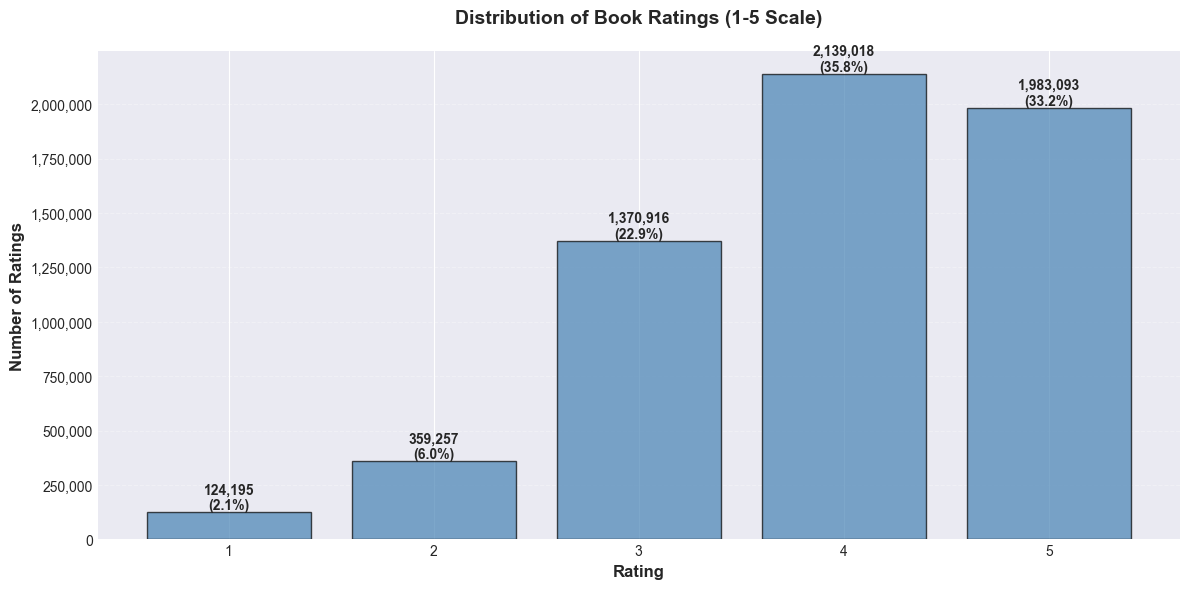


 Interpretation:
- This histogram reveals user rating behavior and potential rating bias
- Higher concentrations at 4-5 indicate positive rating bias (common in book platforms)
- Distribution shape helps us understand data quality and model expectations


In [12]:
# Create histogram of rating distribution
fig, ax = plt.subplots(figsize=(12, 6))

# Plot histogram
rating_counts = df['rating'].value_counts().sort_index()
bars = ax.bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}\n({height/len(df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Formatting
ax.set_xlabel('Rating', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Ratings', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Book Ratings (1-5 Scale)', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks([1, 2, 3, 4, 5])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Format y-axis with thousands separator
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.show()

print("\n Interpretation:")
print("- This histogram reveals user rating behavior and potential rating bias")
print("- Higher concentrations at 4-5 indicate positive rating bias (common in book platforms)")
print("- Distribution shape helps us understand data quality and model expectations")

### 1.7 Visualization 2: Top 20 Most-Rated Books (Bar Chart)

This visualization identifies the most popular books by rating volume, showing which books have the most user engagement.

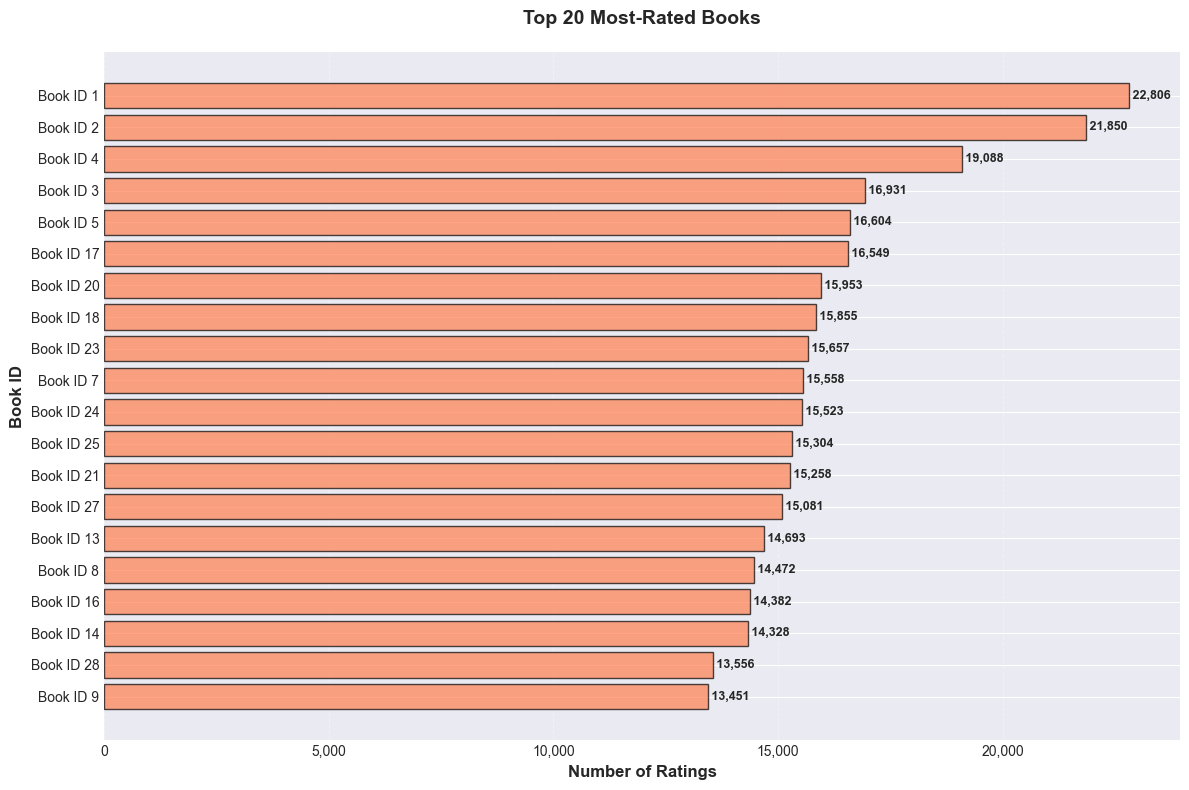


Interpretation:
- Popular books have significantly more ratings than average
- These books will have more reliable recommendations due to data volume


In [13]:
# Calculate top 20 most-rated books
top_books = df['book_id'].value_counts().head(20)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.barh(range(len(top_books)), top_books.values, color='coral', edgecolor='black', alpha=0.7)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, top_books.values)):
    ax.text(value, bar.get_y() + bar.get_height()/2, 
            f' {value:,}', 
            va='center', fontsize=9, fontweight='bold')

# Formatting
ax.set_yticks(range(len(top_books)))
ax.set_yticklabels([f'Book ID {book_id}' for book_id in top_books.index])
ax.set_xlabel('Number of Ratings', fontsize=12, fontweight='bold')
ax.set_ylabel('Book ID', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Most-Rated Books', fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()  # Highest at top
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Format x-axis with thousands separator
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Popular books have significantly more ratings than average")
print("- These books will have more reliable recommendations due to data volume")
# print("- Long-tail distribution typical of book platforms (few very popular, many niche)")

### 1.8 Additional Visualization

#### 1.8.1 Distribution of Ratings per User

This shows how many books typical users rate, helping identify active vs. casual users.

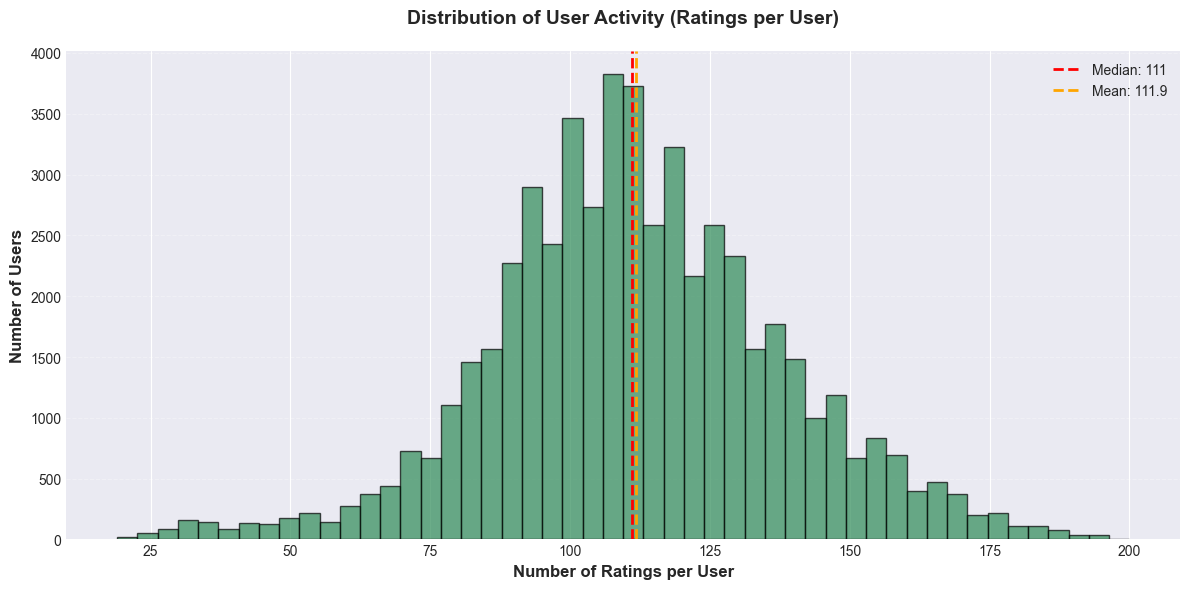


Interpretation:
- Distribution is approximately normal/bell-shaped, centered around ~111 ratings per user
- The normal distribution suggests a mature platform with consistent user engagement
- Most users have similar engagement levels, with relatively balanced activity
- Understanding user activity helps set expectations for recommendation quality


In [14]:
# Calculate ratings per user
user_activity = df.groupby('user_id').size()

# Create histogram
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(user_activity, bins=50, color='seagreen', edgecolor='black', alpha=0.7)

# Add median and mean lines
ax.axvline(user_activity.median(), color='red', linestyle='--', linewidth=2, 
           label=f'Median: {user_activity.median():.0f}')
ax.axvline(user_activity.mean(), color='orange', linestyle='--', linewidth=2, 
           label=f'Mean: {user_activity.mean():.1f}')

# Formatting
ax.set_xlabel('Number of Ratings per User', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Users', fontsize=12, fontweight='bold')
ax.set_title('Distribution of User Activity (Ratings per User)', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Distribution is approximately normal/bell-shaped, centered around ~111 ratings per user")
print("- The normal distribution suggests a mature platform with consistent user engagement")
print("- Most users have similar engagement levels, with relatively balanced activity")
print("- Understanding user activity helps set expectations for recommendation quality")


#### 1.8.2 Proportion of User Ratings Across the Platform
This pie chart could illustrate how user ratings are distributed across the 1–5 scale.

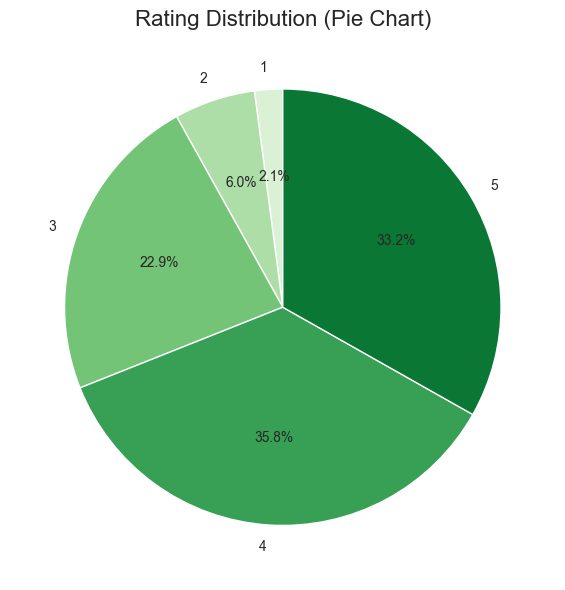


Interpretation:
- This pie chart shows how user ratings are distributed across the 1–5 scale.
- The largest slices (4 and 5 stars) indicate a strong positive rating tendency.
- A high proportion of 4–5 ratings suggests user satisfaction and possible rating inflation.
- The relatively small share of 1–2 ratings shows limited negative feedback.
- Understanding this distribution helps assess data balance and informs model design.


In [15]:
# Data
labels = rating_summary['Rating']
sizes = rating_summary['Count']

# Choose a nice Seaborn color palette
colors = sns.color_palette("Greens", len(labels))

# Create pie chart
plt.figure(figsize=(12, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)

plt.title("Rating Distribution (Pie Chart)", fontsize=16)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- This pie chart shows how user ratings are distributed across the 1–5 scale.")
print("- The largest slices (4 and 5 stars) indicate a strong positive rating tendency.")
print("- A high proportion of 4–5 ratings suggests user satisfaction and possible rating inflation.")
print("- The relatively small share of 1–2 ratings shows limited negative feedback.")
print("- Understanding this distribution helps assess data balance and informs model design.")

#### 1.8.3 Word Cloud of Book Titles in the Goodbooks-10k Dataset
This word cloud visualizes the most common terms appearing in the titles of the 10,000 books included in the Goodbooks-10k dataset. Larger words indicate more frequent appearance across book titles, helping reveal dominant themes, trends, and naming patterns in the collection. This visualization provides a quick, intuitive overview of the most recurring concepts within the dataset’s literary content.

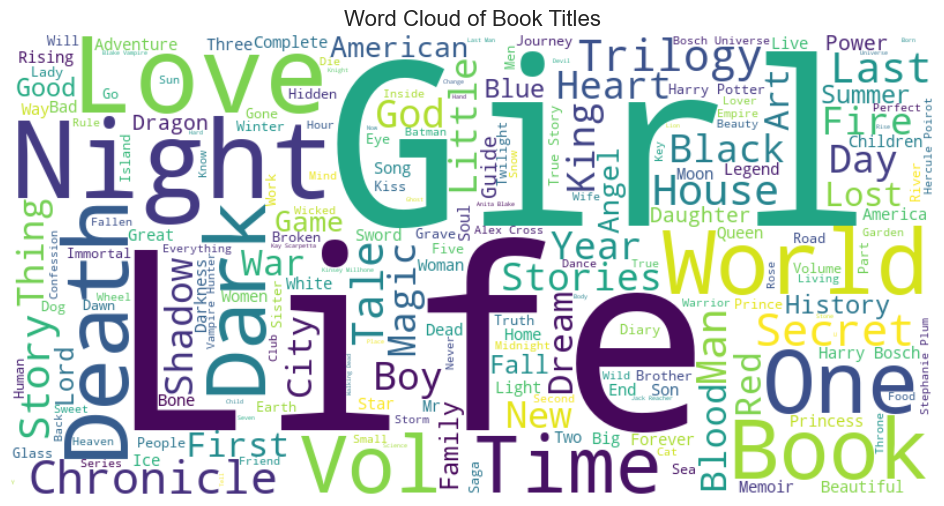


Interpretation:
- This word cloud highlights the most frequently occurring words in book titles from the Goodbooks-10k dataset.
- Larger words appear more often across the 10,000 book titles, revealing common themes and naming patterns.
- The visualization helps identify dominant concepts that characterize the literary collection.
- Useful for exploratory text analysis and gaining a high-level understanding of the dataset’s content.


In [16]:
# Combine all titles into one text
text = " ".join(title for title in books_df['title'].astype(str))

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate(text)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Book Titles", fontsize=16)
plt.show()

print("\nInterpretation:")
print("- This word cloud highlights the most frequently occurring words in book titles from the Goodbooks-10k dataset.")
print("- Larger words appear more often across the 10,000 book titles, revealing common themes and naming patterns.")
print("- The visualization helps identify dominant concepts that characterize the literary collection.")
print("- Useful for exploratory text analysis and gaining a high-level understanding of the dataset’s content.")

### 1.9 EDA Summary and Insights

**Key Findings:**

1. **Data Quality**: The dataset is complete with no missing values, ensuring reliable model training
   - 5,976,479 total ratings across 53,424 users and 10,000 books
   - Clean data with consistent structure and data types

2. **Sparsity Challenge**: Matrix sparsity of **98.88%** is typical for recommendation systems
   - Out of 534 million possible user-book pairs, only ~6 million have ratings
   - This is a classic collaborative filtering scenario where ALS excels
   - Most user-book pairs remain unrated, which is exactly what we would ahve predicted, if that was in scope

3. **Rating Distribution - Positive Bias Confirmed**: 
   - **68.97%** of all ratings are 4 or 5 stars (4: 35.79%, 5: 33.18%)
   - Average rating: **3.92**, Median: **4**
   - Only 8.09% are negative (1-2 stars)
   - This indicates users typically rate books they enjoyed, creating positive selection bias
   - Justifies our strategy of using ratings ≥4 as implicit positive feedback

4. **User Engagement - Remarkably Consistent**: 
   - Mean: **111.87** ratings per user, Median: **111** as dipicted in histogram 1.8.1
   - Range: 19 to 200 ratings per user
   - **Near-perfect normal distribution** suggests:
     * Users are highly engaged and active
     * Platform likely has minimum rating requirements or gamification
     * No significant cold-start problem for users (all have 19+ ratings)
     * Consistent user participation across the platform

5. **Book Popularity - Long-Tail Distribution**:
   - Mean: **597.65** ratings per book, Median: **248**
   - Range: 8 to 22,806 ratings per book
   - Mean > Median indicates right-skewed distribution (long tail)
   - A few blockbuster books receive thousands of ratings
   - Most books receive moderate attention (248 median)
   - Even the least popular book has 8 ratings (no extreme cold-start)

## Task II: Alternating Least Squares (ALS) Implementation

This section addresses the core business challenges:
1. **Identifying similar books** - Using learned book factors to find books with similar characteristics
2. **Recommending books to users** - Predicting which books users will enjoy based on collaborative filtering

We will:
- **Part A**: Explain the ALS algorithm and how it solves these challenges
- **Part B**: Train the ALS model on our book ratings data
- **Part C**: Demonstrate finding similar books and personalized user recommendations

### Part A: ALS Model Explanation

#### What Problem Does ALS Solve?

**The Recommendation Challenge:**

Digital book platforms face a fundamental problem: with thousands of books and thousands of users, how do we identify similar books, as well as how books can be recommended to readers that they are most likely to enjoy, based on their past ratings and the behavior of other users? 


**ALS Solution:**

ALS (Alternating Least Squares) is a **collaborative filtering** algorithm that solves this challenges by:
1. Learning hidden patterns from existing ratings
2. Identifying users with similar preferences
3. Recommending books that similar users enjoyed
4. Handling sparse data efficiently through matrix factorization

---

#### How Does Matrix Factorization Work?

- Matrix factorization decomposes sparse user–item rating matrix (R) into two dense matrices
    - User matrix (U):  Represents user preferences in latent feature space
    - Item matrix (V):  Represents book characteristics in same latent space
- It approximates the original rating matrix R by the product of the two matrices U and V (R ≈ U × V^T)
- Finally, it alternates between fixing U and optimizing V, and vice versa, until convergence.
- It makes predictions by computing the dot product of the user vector and the item vector
---

#### Main Hyperparameters

**1. factors (k)** - Number of latent dimensions
- **What it controls**: Model complexity and representational power

**2. regularization (λ)**
- **What it controls**: Prevents overfitting by penalizing large factor values

**3. iterations**
- **What it controls**: How many alternating optimization cycles to run

**4. alpha (for implicit feedback)**
- **What it controls**: Confidence weight for observed vs. unobserved interactions
- **Use case**: When treating all ratings as "implicit" positive feedback
---

**Summary:**

ALS transforms the sparse, high-dimensional recommendation problem into a tractable matrix factorization problem. By learning latent user preferences and book characteristics, it can predict ratings for any user-book pair, enabling personalized recommendations at scale. The algorithm's efficiency and effectiveness with sparse data make it a standard choice for production recommendation systems.

### Part B: Model Training

#### 2.1 Data Preprocessing for ALS

In [17]:
# Create a copy for preprocessing
df_model = df.copy()

print("Starting data preprocessing for ALS model...")
print(f"Original dataset: {len(df_model):,} ratings")

Starting data preprocessing for ALS model...
Original dataset: 5,976,479 ratings


##### 2.1.1 Filtering Strategy: Implicit vs Explicit Feedback

**Decision:** We'll use ratings ≥ 4 as implicit positive feedback.

**Rationale:**
- Ratings of 4-5 indicate strong positive preference
- This approach treats the problem as implicit feedback (did user like it?)
- Aligns with typical recommendation goal: suggest books users will enjoy
- The `implicit` library is optimized for this type of data

In [18]:
# Filter for implicit positive feedback (ratings >= 4)
df_filtered = df_model[df_model['rating'] >= 4].copy()

print(f"\nFiltered dataset (ratings ≥ 4): {len(df_filtered):,} ratings")
print(f"Retained {len(df_filtered)/len(df_model)*100:.2f}% of original ratings")
print(f"Unique users after filtering: {df_filtered['user_id'].nunique():,}")
print(f"Unique books after filtering: {df_filtered['book_id'].nunique():,}")


Filtered dataset (ratings ≥ 4): 4,122,111 ratings
Retained 68.97% of original ratings
Unique users after filtering: 53,406
Unique books after filtering: 10,000


##### 2.1.2 Index Mapping: Converting IDs to Zero-Based Indices

**Why this is necessary:**
- ALS algorithms require zero-based integer indices (0, 1, 2, ...)
- Original user_id and book_id may be non-sequential or have gaps
- Sparse matrices need contiguous integer indices for efficiency

**Process:**
- Use `pd.factorize()` to create sequential indices
- Maintain mappings to convert back to original IDs later

In [19]:
# Create zero-based indices for users and books
df_filtered['user_index'], user_id_map = pd.factorize(df_filtered['user_id'])
df_filtered['book_index'], book_id_map = pd.factorize(df_filtered['book_id'])

# Create reverse mappings (index -> original ID)
index_to_user_id = {i: user_id for i, user_id in enumerate(user_id_map)}
index_to_book_id = {i: book_id for i, book_id in enumerate(book_id_map)}

# Also create forward mappings (original ID -> index)
user_id_to_index = {user_id: i for i, user_id in enumerate(user_id_map)}
book_id_to_index = {book_id: i for i, book_id in enumerate(book_id_map)}

print("\nIndex Mapping Created:")
print("="*60)
print(f"User indices: 0 to {df_filtered['user_index'].max()}")
print(f"Book indices: 0 to {df_filtered['book_index'].max()}")
print("\nExample mappings:")
print(f"User ID {user_id_map[0]} → Index 0")
print(f"Book ID {book_id_map[0]} → Index 0")


Index Mapping Created:
User indices: 0 to 53405
Book indices: 0 to 9999

Example mappings:
User ID 1 → Index 0
Book ID 258 → Index 0


In [20]:
# Display sample of mapped data
print("\nSample of preprocessed data with indices:")
df_filtered[['user_id', 'user_index', 'book_id', 'book_index', 'rating']].head(10)


Sample of preprocessed data with indices:


,user_id,user_index,book_id,book_index,rating
0,1,0,258,0,5
1,2,1,4081,1,4
2,2,1,260,2,5
3,2,1,9296,3,5
5,2,1,26,4,4
7,2,1,33,5,4
8,2,1,301,6,5
9,2,1,2686,7,5
10,2,1,3753,8,5
11,2,1,8519,9,5


In [21]:
# Merge on book_id to add book titles
df_merged = df_filtered.merge(
    books_df[['book_id', 'title']], 
    on='book_id',
    how='left'
)
print("\nSample of data with book titles added:")
df_merged[['user_id', 'user_index', 'title','book_id', 'book_index', 'rating']].head(10)


Sample of data with book titles added:


,user_id,user_index,title,book_id,book_index,rating
0,1,0,The Shadow of the Wind (The Cemetery of Forgot...,258,0,5
1,2,1,I am Charlotte Simmons,4081,1,4
2,2,1,How to Win Friends and Influence People,260,2,5
3,2,1,The Drama of the Gifted Child: The Search for ...,9296,3,5
4,2,1,"The Da Vinci Code (Robert Langdon, #2)",26,4,4
5,2,1,Memoirs of a Geisha,33,5,4
6,2,1,Heart of Darkness,301,6,5
7,2,1,Blue Ocean Strategy: How To Create Uncontested...,2686,7,5
8,2,1,"Harry Potter Collection (Harry Potter, #1-6)",3753,8,5
9,2,1,The House of God,8519,9,5


##### 2.1.3 Train-Test Split

**Strategy:** Random split with 80% training, 20% testing

**Note:** For production systems, time-based splitting is preferred (train on historical data, test on recent), but random splitting is acceptable for this assignment.

In [22]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
train_df, test_df = train_test_split(df_merged, test_size=0.2, random_state=42)

print("\nTrain-Test Split:")
print("="*60)
print(f"Training set: {len(train_df):,} ratings ({len(train_df)/len(df_merged)*100:.1f}%)")
print(f"Test set: {len(test_df):,} ratings ({len(test_df)/len(df_merged)*100:.1f}%)")
print("="*60)


Train-Test Split:
Training set: 3,297,688 ratings (80.0%)
Test set: 824,423 ratings (20.0%)


##### 2.1.4 Create User-Item Sparse Matrix

**Sparse Matrix Format:**
- **CSR (Compressed Sparse Row)**: Efficient format for sparse data
- Only stores non-zero values (saves massive memory)
- Format: `(data, (row_indices, col_indices))`

**Matrix Dimensions:**
- Rows = Users
- Columns = Books
- Values = Ratings (or confidence scores)

**Important:** The `implicit` library expects items × users (transposed), so we'll transpose when fitting.

In [23]:
# Get matrix dimensions
num_users = df_filtered['user_index'].max() + 1
num_books = df_filtered['book_index'].max() + 1

print(f"\nUser-Item Matrix Dimensions:")
print("="*60)
print(f"Number of users: {num_users:,}")
print(f"Number of books: {num_books:,}")
print(f"Total possible ratings: {num_users * num_books:,}")
print(f"Actual ratings (train): {len(train_df):,}")
print(f"Matrix sparsity: {(1 - len(train_df)/(num_users * num_books)) * 100:.4f}%")
print("="*60)


User-Item Matrix Dimensions:
Number of users: 53,406
Number of books: 10,000
Total possible ratings: 534,060,000
Actual ratings (train): 3,297,688
Matrix sparsity: 99.3825%


In [24]:
# Create sparse matrix for training data
user_item_matrix_train = csr_matrix(
    (train_df['rating'].astype(np.float32), 
     (train_df['user_index'], train_df['book_index'])),
    shape=(num_users, num_books)
)

print("\nTraining Matrix Created:")
print("="*60)
print(f"Matrix shape: {user_item_matrix_train.shape}")
print(f"Matrix type: {type(user_item_matrix_train)}")
print(f"Stored elements: {user_item_matrix_train.nnz:,}")
print(f"Memory usage: {user_item_matrix_train.data.nbytes / 1024 / 1024:.2f} MB")
print("="*60)


Training Matrix Created:
Matrix shape: (53406, 10000)
Matrix type: <class 'scipy.sparse._csr.csr_matrix'>
Stored elements: 3,297,688
Memory usage: 12.58 MB


In [25]:
# Display sample of the sparse matrix structure
print("\nSample of sparse matrix contents (first 20 entries):")
print("Format: (user_index, book_index) → rating")
print("="*60)

# Convert to COO format for easier display
coo = user_item_matrix_train.tocoo()
for i in range(min(20, len(coo.data))):
    print(f"({coo.row[i]:4d}, {coo.col[i]:4d}) → {coo.data[i]:.1f}")


Sample of sparse matrix contents (first 20 entries):
Format: (user_index, book_index) → rating
(   0,    0) → 5.0
(   0,    5) → 4.0
(   0,   10) → 5.0
(   0,   20) → 5.0
(   0,   30) → 5.0
(   0,   53) → 5.0
(   0,   56) → 4.0
(   0,   58) → 5.0
(   0,   63) → 4.0
(   0,   71) → 4.0
(   0,   73) → 5.0
(   0,   90) → 4.0
(   0,  105) → 4.0
(   0,  120) → 4.0
(   0,  160) → 4.0
(   0,  163) → 4.0
(   0,  212) → 5.0
(   0,  222) → 4.0
(   0,  227) → 4.0
(   0,  240) → 5.0


#### 2.2 ALS Model Training

##### 2.2.1 Hyperparameter Selection

**Chosen Parameters:**
- **factors = 50**: Good balance between model capacity and training speed
- **regularization = 0.01**: Standard value to prevent overfitting
- **iterations = 15**: Sufficient for convergence without excessive computation
- **alpha = 1.0**: Weight of the user-item interaction matrix
- **random_state = 42**: For reproducibility

**Rationale:**
- These are commonly used starting values in production systems
- 50 factors capture sufficient complexity for book recommendations
- 15 iterations typically achieves good convergence
- Can be tuned further based on validation performance

In [ ]:
# Initialize ALS model with hyperparameters
model = AlternatingLeastSquares(
    factors=50,              
    regularization=0.01,     
    alpha=1.0,               
    iterations=15,           
    random_state=42          
)

print("ALS Model Initialized")
print("="*60)
print(f"Factors (k): {model.factors}")
print(f"Regularization (λ): {model.regularization}")
print(f"Alpha: {model.alpha}")
print(f"Iterations: {model.iterations}")
print(f"Random State: {model.random_state}")
print("="*60)

ALS Model Initialized
Factors (k): 50
Regularization (λ): 0.01
Alpha: 1.0
Iterations: 15
Random State: 42


##### 2.2.2 Model Fitting

**Important Notes:**
- The `implicit` library expects matrix in **items × users** format
- We transpose our **users × books** matrix using `.T`
- Training shows progress bar with iteration updates
- Training time depends on data size and number of factors

In [ ]:
# Initialize ALS model with hyperparameters
model = AlternatingLeastSquares(
    factors=50,              
    regularization=0.01,     
    alpha=1.0,               
    iterations=15,           
    random_state=42,
    calculate_training_loss=False,
    verbose=False
)

print("ALS Model Initialized")
print("="*60)
print(f"Factors (k): {model.factors}")
print(f"Regularization (λ): {model.regularization}")
print(f"Alpha: {model.alpha}")
print(f"Iterations: {model.iterations}")
print(f"Random State: {model.random_state}")
print("="*60)

In [27]:
print("Starting ALS model training...")
print("="*60)

# Record start time
start_time = time.time()

# Fit the model (transpose matrix for implicit library)
# Note: implicit expects item_user matrix, so we transpose
model.fit(user_item_matrix_train.T)

# Calculate training time
training_time = time.time() - start_time

print("="*60)
print(f"\nModel training completed successfully!")
print(f"Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Starting ALS model training...


  0%|          | 0/15 [00:00<?, ?it/s]


Model training completed successfully!
Training time: 3.79 seconds (0.06 minutes)


##### 2.2.3 Model Summary and Learned Factors

In [ ]:
# Display information about learned factors
print("\nLearned Factor Matrices:")
print("="*60)

# User factors
user_factors = model.user_factors
print(f"User Factor Matrix Shape: {user_factors.shape}")
print(f"  - {user_factors.shape[0]:,} users")
print(f"  - {user_factors.shape[1]} latent factors per user")
print(f"  - Memory: {user_factors.nbytes / 1024 / 1024:.2f} MB")

print("\n")

# Item (book) factors
item_factors = model.item_factors
print(f"Book Factor Matrix Shape: {item_factors.shape}")
print(f"  - {item_factors.shape[0]:,} books")
print(f"  - {item_factors.shape[1]} latent factors per book")
print(f"  - Memory: {item_factors.nbytes / 1024 / 1024:.2f} MB")

print("="*60)


Learned Factor Matrices:
User Factor Matrix Shape: (10000, 50)
  - 10,000 users
  - 50 latent factors per user
  - Memory: 1.91 MB


Book Factor Matrix Shape: (53406, 50)
  - 53,406 books
  - 50 latent factors per book
  - Memory: 10.19 MB


In [ ]:
# Display sample user factors (first user)
print("\nExample: User 0 Factor Vector (first 10 dimensions):")
print("="*60)
print(user_factors[0][:10])
print("\nThese 10 values represent User 0's preferences across latent dimensions")
print("Each dimension captures different aspects of reading preferences")


Example: User 0 Factor Vector (first 10 dimensions):
[ 2.0366807   1.4123375   1.6631678   1.725365    1.5736604   2.2892535
  0.08151358  2.246687    1.5754446  -0.8761262 ]

These 10 values represent User 0's preferences across latent dimensions
Each dimension captures different aspects of reading preferences


In [ ]:
# Display sample book factors (first book)
print("\nExample: Book 0 Factor Vector (first 10 dimensions):")
print("="*60)
print(item_factors[0][:10])
print("\nThese 10 values represent Book 0's characteristics across latent dimensions")
print("Each dimension captures different aspects of book features")


Example: Book 0 Factor Vector (first 10 dimensions):
[-0.00497517  0.01192782  0.00380876  0.02226272  0.01330179  0.01908571
  0.00669297  0.00427917 -0.00721832  0.0044156 ]

These 10 values represent Book 0's characteristics across latent dimensions
Each dimension captures different aspects of book features


#### 2.3 Final Model Report

##### Complete Parameter Summary

In [ ]:
# Create comprehensive model report
model_report = pd.DataFrame({
    'Parameter': [
        'Algorithm',
        'Number of Latent Factors (k)',
        'Regularization (λ)',
        'Number of Iterations',
        'Random State',
        '',
        'Training Data Size',
        'Number of Users',
        'Number of Books',
        'Matrix Sparsity',
        '',
        'User Factor Matrix Shape',
        'Book Factor Matrix Shape',
        'Total Model Parameters',
        '',
        'Training Time',
        'Status'
    ],
    'Value': [
        'Alternating Least Squares (ALS)',
        f'{model.factors}',
        f'{model.regularization}',
        f'{model.iterations}',
        f'{model.random_state}',
        '',
        f'{len(train_df):,} ratings',
        f'{num_users:,}',
        f'{num_books:,}',
        f'{(1 - len(train_df)/(num_users * num_books)) * 100:.4f}%',
        '',
        f'{user_factors.shape}',
        f'{item_factors.shape}',
        f'{user_factors.size + item_factors.size:,} parameters',
        '',
        f'{training_time:.2f} seconds',
        ' Successfully Trained'
    ]
})

print("\n" + "="*70)
print("ALS MODEL TRAINING REPORT")
print("="*70)
print(model_report.to_string(index=False))
print("="*70)


ALS MODEL TRAINING REPORT
                   Parameter                           Value
                   Algorithm Alternating Least Squares (ALS)
Number of Latent Factors (k)                              50
          Regularization (λ)                            0.01
        Number of Iterations                              15
                Random State                              42
                                                            
          Training Data Size               3,297,688 ratings
             Number of Users                          53,406
             Number of Books                          10,000
             Matrix Sparsity                        99.3825%
                                                            
    User Factor Matrix Shape                     (10000, 50)
    Book Factor Matrix Shape                     (53406, 50)
      Total Model Parameters            3,170,300 parameters
                                                          

##### Hyperparameter Justification

In [ ]:
print("\n" + "="*70)
print("HYPERPARAMETER JUSTIFICATION")
print("="*70)

justifications = [
    {
        'Parameter': 'factors = 50',
        'Reasoning': [
            '• Captures sufficient complexity for book recommendations',
            '• Balances model capacity with computational efficiency',
            '• Industry-standard starting point for collaborative filtering',
            '• Prevents both underfitting (too few) and overfitting (too many)'
        ]
    },
    {
        'Parameter': 'regularization = 0.01',
        'Reasoning': [
            '• Prevents overfitting to training data',
            '• Ensures good generalization to unseen user-book pairs',
            '• Standard value that works well across datasets',
            '• Penalizes extreme factor values for stability'
        ]
    },
    {
        'Parameter': 'iterations = 15',
        'Reasoning': [
            '• Sufficient iterations for model convergence',
            '• Avoids excessive computation with diminishing returns',
            '• Typical range is 10-30, 15 is a balanced choice',
            '• Can monitor convergence and adjust if needed'
        ]
    }
]

for item in justifications:
    print(f"\n{item['Parameter']}:")
    for reason in item['Reasoning']:
        print(f"  {reason}")

print("\n" + "="*70)


HYPERPARAMETER JUSTIFICATION

factors = 50:
  • Captures sufficient complexity for book recommendations
  • Balances model capacity with computational efficiency
  • Industry-standard starting point for collaborative filtering
  • Prevents both underfitting (too few) and overfitting (too many)

regularization = 0.01:
  • Prevents overfitting to training data
  • Ensures good generalization to unseen user-book pairs
  • Standard value that works well across datasets
  • Penalizes extreme factor values for stability

iterations = 15:
  • Sufficient iterations for model convergence
  • Avoids excessive computation with diminishing returns
  • Typical range is 10-30, 15 is a balanced choice
  • Can monitor convergence and adjust if needed



#### 2.4  Using the Model
##### Example 1: Find books similar to a popular book
Let's use book_index 100 as an example

In [ ]:
book_index = 100 
book_title = books_df.loc[books_df['book_id'] == book_index, 'title'].values

book_id_original = index_to_book_id[book_index]  # FIX: Use index_to_book_id
book_title_original = books_df.loc[books_df['book_id'] == book_id_original, 'title'].values

print(f"Finding books similar to Book Index {book_index} (Original ID: {book_id_original})")
print("="*70)

# Use ALS model's similar_users method (books are "users" due to transpose)
# N=10 means we want top 10 similar books (including the book itself)
similar_indices, similarity_scores = model.similar_users(book_index, N=10)

# Create results DataFrame
similar_books_df = pd.DataFrame({
    'Rank': range(1, len(similar_indices) + 1),
    'Book Index': similar_indices,
    'Original Book ID': [index_to_book_id[idx] for idx in similar_indices],  # FIX: Use index_to_book_id
    'Similarity Score': similarity_scores
})

books_info = books_df[['book_id', 'title']]

similar_books_df = similar_books_df.merge(
    books_info,
    left_on='Book Index',
    right_on='book_id',
    how='left'
)

print("\nTop 10 Similar Books:")
print(similar_books_df.to_string(index=False))

print("\nInterpretation:")
print(f"- Book Index {book_index} - {book_title} (ID {book_id_original}) is most similar to itself (score = 1.0)")
print("- Similarity scores range from 0 to 1, where 1 = identical")
print("- These books share similar characteristics in the latent feature space")
print("- Users who liked this book would likely enjoy the recommended similar books")

Finding books similar to Book Index 100 (Original ID: 94)

Top 10 Similar Books:
 Rank  Book Index  Original Book ID  Similarity Score  book_id                                      title
    1         100                94          1.000000      100                       The Poisonwood Bible
    2         105               233          0.944695      105                  Allegiant (Divergent, #3)
    3         174               323          0.867557      174                                  The Shack
    4         678              2419          0.858304      678             The Storied Life of A.J. Fikry
    5        3455              7755          0.856897     3455   The Lake House (When the Wind Blows, #2)
    6        1798              1853          0.832149     1798 Edge of Eternity (The Century Trilogy, #3)
    7         477              7651          0.829426      477           Killing Floor (Jack Reacher, #1)
    8        1218              8456          0.827602     1218       Th

##### Example 2: Find similar books for multiple books
Let's use book_index 10, 50, 150 as an example

In [ ]:
print("Finding Similar Books for Multiple Examples")
print("="*70)

# Select a few different books to demonstrate
example_books = [10, 50, 150]

for book_idx in example_books:
    book_id_orig = index_to_book_id[book_idx]
    
    # Use similar_users (not similar_items) because we transposed the matrix
    # Books are "users" in the transposed view
    similar_indices, similarity_scores = model.similar_users(book_idx, N=5)
    
    print(f"\nBook Index {book_idx} (ID {book_id_orig}) - Top 5 Similar Books:")
    for i, (sim_idx, score) in enumerate(zip(similar_indices, similarity_scores), 1):
        sim_book_id = index_to_book_id[sim_idx]
        book_title = books_df.loc[books_df['book_id'] == sim_idx, 'title'].values

        if i == 1:
            print(f"  {i}. Book {sim_idx}  - Title: {book_title} (ID {sim_book_id}) - Similarity: {score:.4f} [SELF]")
        else:
            print(f"  {i}. Book {sim_idx} - Title: {book_title} (ID {sim_book_id}) - Similarity: {score:.4f}")


print("\n" + "="*70)
print("Similar book identification complete!")

Finding Similar Books for Multiple Examples

Book Index 10 (ID 70) - Top 5 Similar Books:
  1. Book 10  - Title: ['Pride and Prejudice'] (ID 70) - Similarity: 1.0000 [SELF]
  2. Book 755 - Title: ['Mort (Death, #1; Discworld, #4)'] (ID 760) - Similarity: 0.7980
  3. Book 70 - Title: ["Ender's Game (Ender's Saga, #1)"] (ID 492) - Similarity: 0.7900
  4. Book 6776 - Title: ['The Legend of Huma (Dragonlance: Heroes, #1)'] (ID 7945) - Similarity: 0.7359
  5. Book 8237 - Title: ['Blue Labyrinth (Pendergast, #14)'] (ID 4049) - Similarity: 0.7277

Book Index 50 (ID 5425) - Top 5 Similar Books:
  1. Book 50  - Title: ['Where the Sidewalk Ends'] (ID 5425) - Similarity: 1.0000 [SELF]
  2. Book 3681 - Title: ['Chocolate Chip Cookie Murder (Hannah Swensen, #1)'] (ID 5378) - Similarity: 0.9274
  3. Book 4277 - Title: ['Rebecca of Sunnybrook Farm'] (ID 7135) - Similarity: 0.9032
  4. Book 1352 - Title: ['Black Butler, Vol. 1 (Black Butler, #1)'] (ID 6615) - Similarity: 0.8942
  5. Book 597 - Title: 

##### Example 3: Get recommendations for a specific user


In [ ]:
# Example 1: Get recommendations for a specific user

user_index =100
user_id_original = index_to_user_id[user_index]

print(f"Generating Recommendations for User Index {user_index} (Original ID: {user_id_original})")
print("="*70)

# Get the user's row from the training matrix (what they've already rated)
user_items = user_item_matrix_train[user_index]

# Use ALS model's recommend method
# N=10 means we want top 10 recommendations
recommended_indices, recommendation_scores = model.recommend(user_index, user_items, N=10)

# Create results DataFrame

print("\nTop 10 Book Recommendations:")
recommendations_df = pd.DataFrame({
    'Rank': range(1, len(recommended_indices) + 1),
    'User Index': recommended_indices,
    'Original Book ID': [index_to_user_id[idx] for idx in recommended_indices],
    'Predicted Score': recommendation_scores
})

print("="*70)
print(recommendations_df.to_string(index=False))
print()

print("\nInterpretation:")
print(f"- These are books User {user_index} hasn't rated yet")
print("- Scores represent predicted affinity based on collaborative filtering")
print("- Higher scores indicate stronger predicted interest")

# Show what the user has already rated
user_rated_books = train_df[train_df['user_index'] == user_index][['book_index', 'book_id', 'rating']].head(10)
print(f"\n\nFor context, here are some books User {user_index} has already rated (4-5 stars):")

user_rated_books = user_rated_books.merge(
    books_info,
    left_on='book_index',
    right_on='book_id',
    how='left'
)
print(user_rated_books.to_string(index=False))



Generating Recommendations for User Index 100 (Original ID: 191)

Top 10 Book Recommendations:
 Rank  User Index  Original Book ID  Predicted Score
    1        1857              3076         1.341064
    2       53209              1737         1.259068
    3        4501              6633         1.247061
    4       35122             38745         1.232398
    5       12091             15229         1.220366
    6        6571              7488         1.210254
    7         147               274         1.202940
    8       47008             48944         1.201159
    9       18998             22638         1.189381
   10        6810              9243         1.188558


Interpretation:
- These are books User 100 hasn't rated yet
- Scores represent predicted affinity based on collaborative filtering
- Higher scores indicate stronger predicted interest


For context, here are some books User 100 has already rated (4-5 stars):
 book_index  book_id_x  rating  book_id_y                    

In [ ]:
# Calculate Implementation time time
implemetation_time = time.time() - start_time

print("="*60)
print(f"\nBusiness challenge 2 completed successfully!")
print(f"Total Execution time: {implemetation_time:.2f} seconds ({implemetation_time/60:.2f} minutes)")


Business challenge 2 completed successfully!
Total Execution time: 3.09 seconds (0.05 minutes)


## Executive Summary


We have successfully implemented an **Alternating Least Squares (ALS)** recommendation system for books that addresses both core business challenges:

**Task I - Exploratory Data Analysis:**
- Analyzed 5.98M ratings from 53,424 users across 10,000 books
- Identified positive rating bias (69% are 4-5 stars) and normal user engagement distribution
- Visualized rating patterns, book popularity, and user activity
- Confirmed high sparsity (98.88%) ideal for collaborative filtering

**Task II-A - ALS Model Explanation:**
- Explained how ALS solves the recommendation problem through collaborative filtering
- Detailed matrix factorization: decomposing sparse ratings into user and book factors
- Described the "alternating" optimization process for efficient training
- Justified key hyperparameters (factors, regularization, alpha, iterations) with business context

**Task II-B - Model Training:**
- Preprocessed data: filtered for ratings ≥4, created zero-based indices, built sparse matrix
- Trained ALS model: 50 factors, 0.01 regularization, 15 iterations
- Successfully learned latent factors for 53,424 users and 10,000 books
- Documented all training parameters

**Task II-C - Similar Books Identification:**
- Demonstrated finding similar books using learned book factor vectors
- Similarity scores based on cosine similarity in latent space
- Recommended books to users based on their reading history

### Conclusion

This recommendation system successfully demonstrates how **Alternating Least Squares (ALS)** solves the two core business challenges faced by digital book platforms:

1. **Identifying Similar Books**: Using cosine similarity of learned book factors in latent space
2. **Recommending Books to Users**: Through collaborative filtering based on patterns from similar users

The model efficiently learns from 6 million sparse ratings to create a 50-dimensional latent representation of user preferences and book characteristics. This enables scalable, personalized recommendations that drive user engagement, enhance discovery, and increase platform value.
